<a href="https://colab.research.google.com/github/surya81/Encoder-Decoder-Model/blob/main/vanilla_autoencoder_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 49 kB 6.1 MB/s 
     |████████████████████████████████| 235 kB 57.1 MB/s 
     |████████████████████████████████| 78 kB 2.9 MB/s 
     |████████████████████████████████| 948 kB 59.6 MB/s 
     |████████████████████████████████| 58 kB 7.1 MB/s 
     |████████████████████████████████| 51 kB 7.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [ ]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [ ]:

trn_ds = MNIST('/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('/content/', transform=img_transform, train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [ ]:
batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latend_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), 
            nn.ReLU(True),
            nn.Linear(128, 64), 
            nn.ReLU(True), 
            #nn.Linear(64, 12),  nn.ReLU(True), 
            nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(
            #nn.Linear(latent_dim, 12), nn.ReLU(True),
            nn.Linear(latent_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128), 
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
            nn.Tanh())

    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

In [ ]:
!pip install torch_summary
from torchsummary import summary
model = AutoEncoder(3).to(device)
summary(model,torch.zeros(2,1,28,28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 3]                   195
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  256
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 3]                   195
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  256
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-1, 784]                 101,136
|    └─Tanh: 2-11                        [-1, 784]                 

In [ ]:
def train_batch(input, model, criterion, optimizer):
  model.train()
  optimizer.zero_grad()
  output = model(input)
  loss = criterion(output, input)
  loss.backward()
  optimizer.step()
  return loss


In [ ]:
import torch
@torch.no_grad()
def validate_batch(input,model,criterion):
  model.eval()
  output = model(input)
  loss = criterion(output,input)
  return loss

In [ ]:
model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(),lr = 0.001,weight_decay = 1e-5)

In [ ]:
num_epochs = 10
log = Report(num_epochs)
for epoch in range(num_epochs):
  N = len(trn_dl)
  for ix, (data, _) in enumerate(trn_dl):
    loss = train_batch(data, model, criterion, optimizer)
    log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')
  N = len(val_dl)
  for ix, (data, _) in enumerate(val_dl):
    loss = validate_batch(data, model, criterion)
    log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
  log.report_avgs(epoch+1)

EPOCH: 1.000	trn_loss: 0.147	val_loss: 0.146	(23.02s - 207.18s remaining)
EPOCH: 2.000	trn_loss: 0.145	val_loss: 0.145	(38.77s - 155.08s remaining)
EPOCH: 3.000	trn_loss: 0.144	val_loss: 0.143	(52.58s - 122.68s remaining)
EPOCH: 4.000	trn_loss: 0.142	val_loss: 0.141	(66.54s - 99.82s remaining)
EPOCH: 5.000	trn_loss: 0.141	val_loss: 0.140	(80.72s - 80.72s remaining)
EPOCH: 6.000	trn_loss: 0.139	val_loss: 0.139	(95.53s - 63.69s remaining)
EPOCH: 7.000	trn_loss: 0.138	val_loss: 0.138	(109.46s - 46.91s remaining)
EPOCH: 8.000	trn_loss: 0.137	val_loss: 0.137	(124.36s - 31.09s remaining)
EPOCH: 9.000	trn_loss: 0.137	val_loss: 0.136	(138.51s - 15.39s remaining)
EPOCH: 10.000	trn_loss: 0.136	val_loss: 0.136	(152.70s - 0.00s remaining)


100%|██████████| 111/111 [00:00<00:00, 1457.14it/s]


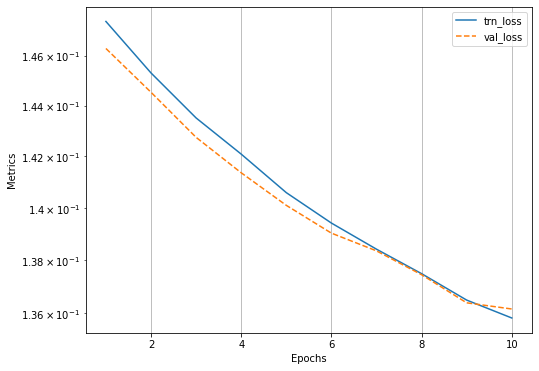

In [ ]:
log.plot_epochs(log=True)

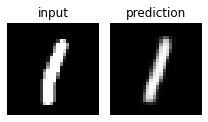

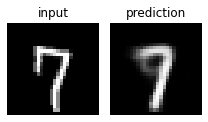

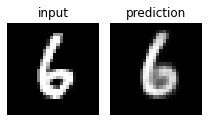

In [ ]:
for _ in range(3):
  ix = np.random.randint(len(val_ds))
  im, _ = val_ds[ix]
  _im = model(im[None])[0]
  fig, ax = plt.subplots(1, 2, figsize=(3,3))
  show(im[0], ax=ax[0], title='input')
  show(_im[0], ax=ax[1], title='prediction')
  plt.tight_layout()
  plt.show()